In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt

In [ ]:
ticker = "RELIANCE.NS"

data = yf.download(
    ticker,
    start="2018-01-01",
    end="2024-01-01",
    progress=False
)

prices = data["Close"].dropna()
returns = np.log(prices / prices.shift(1)).dropna()

sigma = returns.std() * np.sqrt(252)

In [ ]:
S0 = prices.iloc[-1]
K = S0
T = 0.5
r = 0.06

N = 126        # hedging steps (~6 months)
dt = T / N
n_sims = 2000  # number of Monte Carlo paths

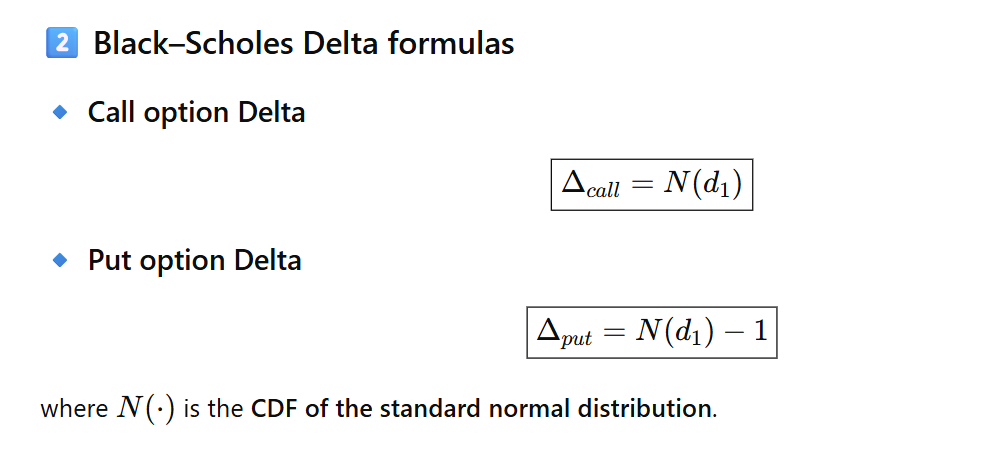

In [ ]:
def bs_call_price(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

def bs_delta_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    return norm.cdf(d1)

In [ ]:
prices_sim = np.zeros(N+1)
prices_sim[0] = S0


In [ ]:
prices_sim[-1]

In [ ]:
def simulate_pnl():
    # Simulate stock path
    prices_sim = np.zeros(N+1)
    prices_sim[0] = S0

    for t in range(1, N+1):
        z = np.random.normal()
        prices_sim[t] = prices_sim[t-1] * np.exp(
            (r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*z
        )

    # ----- UNHEDGED SHORT CALL -----
    call_payoff = np.maximum(prices_sim[-1] - K, 0)
    unhedged_pnl = bs_call_price(S0, K, T, r, sigma) - call_payoff

    # ----- DELTA-HEDGED SHORT CALL -----
    call_price_0 = bs_call_price(S0, K, T, r, sigma)
    delta = bs_delta_call(S0, K, T, r, sigma)

    shares = delta
    cash = call_price_0 - delta * S0

    for t in range(1, N+1):
        tau = max(T - t*dt, 1e-6)
        S = prices_sim[t]

        new_delta = bs_delta_call(S, K, tau, r, sigma)
        delta_change = new_delta - shares

        cash -= delta_change * S
        shares = new_delta
        cash *= np.exp(r * dt)

    hedged_pnl = cash + shares * prices_sim[-1] - np.maximum(prices_sim[-1] - K, 0)

    return unhedged_pnl, hedged_pnl


In [15]:
unhedged_pnls = []
hedged_pnls = []

for _ in range(n_sims):
    u, h = simulate_pnl()
    unhedged_pnls.append(u)
    hedged_pnls.append(h)

unhedged_pnls = np.array(unhedged_pnls)
hedged_pnls = np.array(hedged_pnls)

/tmp/ipython-input-1522445941.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  prices_sim[0] = S0
/tmp/ipython-input-1522445941.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  prices_sim[t] = prices_sim[t-1] * np.exp(


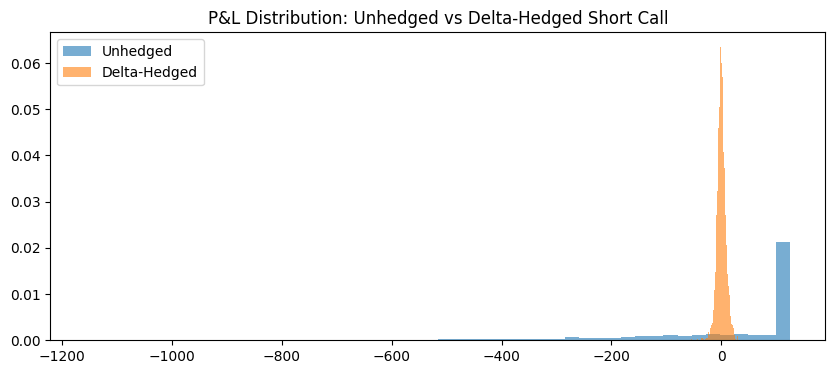

In [16]:
plt.figure(figsize=(10,4))
plt.hist(unhedged_pnls, bins=50, alpha=0.6, density=True, label="Unhedged")
plt.hist(hedged_pnls, bins=50, alpha=0.6, density=True, label="Delta-Hedged")
plt.legend()
plt.title("P&L Distribution: Unhedged vs Delta-Hedged Short Call")
plt.show()


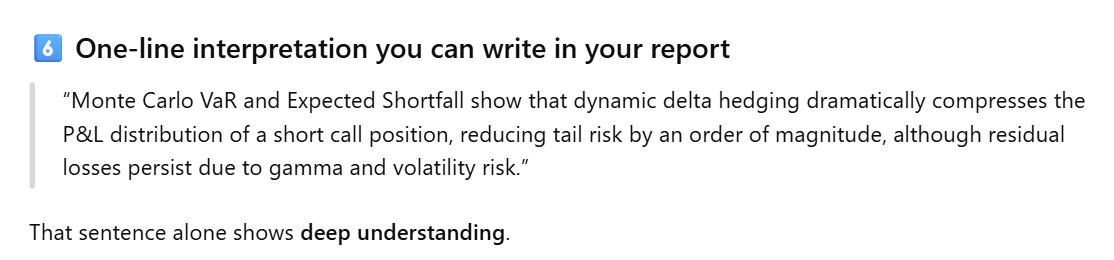

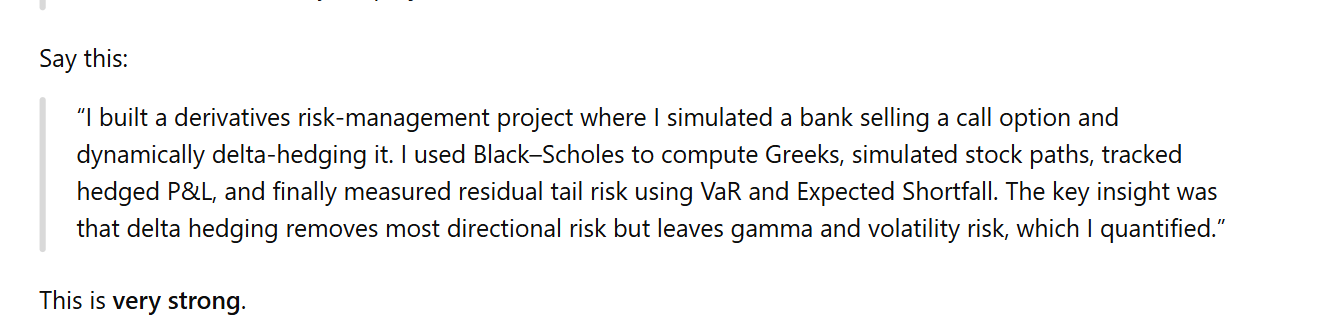

In [17]:
def var_es(pnls, alpha=0.05):
    var = np.percentile(pnls, 100*alpha)
    es = pnls[pnls <= var].mean()
    return var, es


In [18]:
var_u, es_u = var_es(unhedged_pnls)
var_h, es_h = var_es(hedged_pnls)

risk_table = pd.DataFrame({
    "Position": ["Unhedged Short Call", "Delta-Hedged Short Call"],
    "VaR (5%)": [var_u, var_h],
    "Expected Shortfall (5%)": [es_u, es_h]
})

risk_table


,Position,VaR (5%),Expected Shortfall (5%)
0,Unhedged Short Call,-402.071518,-581.639247
1,Delta-Hedged Short Call,-12.386252,-18.478917
